# Set up

In [1]:
import torch
import torch.nn as nn
import numpy as np
import xarray as xr
from torch.utils.data import TensorDataset, DataLoader
from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet  
from utils import *
from tqdm import tqdm


setup_random_seeds(42)
device = get_device()

base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

Using device: cpu


/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x787a00311e80>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x787a00311e80>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x787a00311e80>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


In [2]:
%%time
# Model 1: ZCA NLL Loss with SSH+SST input

# Prepare training data for normalization statistics (SSH+SST)
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

# Prepare test data (SSH+SST) 
x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)

# Normalize test data for model input
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

# Prepare test targets
y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

# Create test dataset and loader
test_dataset_sst = TensorDataset(x_test_normalized, y_test)
test_loader_sst = DataLoader(test_dataset_sst, batch_size=32*4, shuffle=False)

# Load model
model_sst_ssh = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_sst_ssh.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model_sst_ssh.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_sst_ssh.eval()
results_sst_ssh = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(tqdm(test_loader_sst)):
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices.extend(current_batch_indices)
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)

        outputs = model_sst_ssh(batch_x)
        
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=100)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_sst_ssh['ssh'].append(ssh_batch_original.cpu().numpy())
        results_sst_ssh['sst'].append(sst_batch_original.cpu().numpy())
        results_sst_ssh['ubm_true'].append(ubm_true.cpu().numpy())
        results_sst_ssh['bm_true'].append(bm_true.cpu().numpy())
        results_sst_ssh['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_sst_ssh['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_sst_ssh['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_sst_ssh['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_sst_ssh:
    results_sst_ssh[key] = np.concatenate(results_sst_ssh[key], axis=0)

print("Model 1 evaluation complete!")

<timed exec>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
100%|██████████| 29/29 [01:34<00:00,  3.25s/it]


Model 1 evaluation complete!
CPU times: user 14min 16s, sys: 1min 19s, total: 15min 36s
Wall time: 1min 41s


In [3]:
# Create xarray datasets and save results
models_results = [
    ('sst_ssh', results_sst_ssh, True, True),
    #('ssh_only', results_ssh_only, True, False), 
    #('mse_only', results_mse_only, False, True)
]

# Store all datasets
eval_datasets = {}

for model_name, results, has_ensembles, has_sst in models_results:
    print(f"Creating dataset for {model_name}...")
    
    eval_dataset = create_evaluation_dataset(results, model_name, has_ensembles, has_sst, stochastic_samples=100)
    
    # Store the dataset
    eval_datasets[model_name] = eval_dataset

Creating dataset for sst_ssh...
Adding ensemble data with shape: (3645, 100, 1, 80, 80)


In [4]:
# Chunk for some parallelization (not needed, but makes things potentially faster)
# Add km coordinates

for k in eval_datasets.keys(): 
    eval_datasets[k] = eval_datasets[k].chunk(chunks={'sample' : 100, 'stochastic_sample':100}) 
    eval_datasets[k] = eval_datasets[k].assign_coords(i = eval_datasets[k].i *1.5, j = eval_datasets[k].j *1.5)

In [5]:
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx  = np.where(clean_mask)[0]

In [6]:
clean_idx

array([  28,   29,   30, ..., 3609, 3610, 3611], shape=(2907,))

# Bin by where 

In [7]:
# Analysis by PSD Intersection Bins (Log-spaced)
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from scipy.interpolate import interp1d
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

def isotropic_spectra(data):
    """Calculate the isotropic power spectrum of input data."""
    iso_psd = xrft.isotropic_power_spectrum(
        data, 
        dim=['i', 'j'], 
        detrend='constant', 
        window=True,
        nfactor=2
    )
    return iso_psd

def calculate_psd_km(field, dx=1.5):
    """Calculate PSD with spatial coordinates in km."""
    i_km = np.arange(field.shape[0]) * dx
    j_km = np.arange(field.shape[1]) * dx
    da = xr.DataArray(
        field,
        dims=['i', 'j'],
        coords={'i': i_km, 'j': j_km},
        name='field'
    )
    return isotropic_spectra(da)



def find_psd_intersection(bm_psd, ubm_psd, wavenumbers):
    """Find the first intersection point (smallest wavenumber) between BM and UBM PSDs"""
    try:
        # Find where UBM crosses above BM (or vice versa)
        diff = ubm_psd - bm_psd
        
        # Look for sign changes
        sign_changes = np.where(np.diff(np.sign(diff)))[0]
        
        if len(sign_changes) == 0:
            return None  # No intersection found
        
        # Return the wavenumber of the first intersection (smallest wavenumber)
        first_intersection_idx = sign_changes[0]
        
        # Linear interpolation to get more precise intersection point
        k1, k2 = wavenumbers[first_intersection_idx], wavenumbers[first_intersection_idx + 1]
        d1, d2 = diff[first_intersection_idx], diff[first_intersection_idx + 1]
        
        # Linear interpolation: find where diff crosses zero
        intersection_k = k1 - d1 * (k2 - k1) / (d2 - d1)
        
        return intersection_k
        
    except Exception as e:
        return None

def create_log_bins(k_min=1/120, k_max=1/2, n_bins=3):
    """Create equally spaced log bins across the wavenumber range"""
    log_min = np.log10(k_min)
    log_max = np.log10(k_max)
    
    # Create bin edges in log space
    log_edges = np.linspace(log_min, log_max, n_bins + 1)
    bin_edges = 10**log_edges
    
    return bin_edges

def custom_bins(): 
    return np.array([1/120, 1/40, 1/10, 1/1])

def bin_samples_by_intersection_logspace(eval_dataset, test_data, clean_idx_subset):
    """Bin samples based on BM-UBM PSD intersection wavenumbers using log-spaced bins"""
    
    # Create 4 equally spaced log bins
    #bin_edges = create_log_bins()
    bin_edges = custom_bins()
    n_bins = len(bin_edges) - 1
    
    # Initialize bins
    bins = {f'bin_{i}': [] for i in range(n_bins)}
    no_intersection_samples = []
    intersection_wavenumbers = []

    print("Bin edges (spatial scale in km):")
    for i in range(n_bins):
        km_low = 1/bin_edges[i+1]  # Note: reversed order since 1/k
        km_high = 1/bin_edges[i]
        print(f"Bin {i+1}: [{km_low:.1f}, {km_high:.1f}) km")
    
    # print("Bin edges (wavenumber):")
    # for i in range(n_bins):
    #     print(f"Bin {i+1}: [{bin_edges[i]:.4f}, {bin_edges[i+1]:.4f})")
    
    for sample_idx in tqdm(clean_idx_subset): #!! these kind of for loops are very slow.
        try:
            # Get true BM and UBM for this sample
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            
            # Skip samples with NaNs
            if np.any(np.isnan(bm_true)) or np.any(np.isnan(ubm_true)):
                continue
                
            # Calculate PSDs
            psd_bm = calculate_psd_km(bm_true)
            #psd_bm = isotropic_spectra(bm_true)
            psd_ubm = calculate_psd_km(ubm_true)
            #psd_ubm = isotropic_spectra(ubm_true)
            
            wavenumbers = psd_bm[list(psd_bm.coords.keys())[0]].values
            
            # Find intersection
            intersection_k = find_psd_intersection(psd_bm.values, psd_ubm.values, wavenumbers)
            
            # Bin the sample
            if intersection_k is None:
                no_intersection_samples.append(sample_idx)
            else:
                intersection_wavenumbers.append(intersection_k)
                
                # Find which bin this intersection falls into
                bin_idx = np.digitize(intersection_k, bin_edges) - 1
                
                # Make sure it's within valid range
                if 0 <= bin_idx < n_bins:
                    bins[f'bin_{bin_idx}'].append(sample_idx)
                else:
                    no_intersection_samples.append(sample_idx)
                
        except Exception as e:
            continue
    
    return bins, no_intersection_samples, intersection_wavenumbers, bin_edges


In [8]:
# Bin samples by intersection wavenumbers
bins, no_intersection, intersection_ks, bin_edges = bin_samples_by_intersection_logspace(
    eval_datasets['sst_ssh'], test, clean_idx)

Bin edges (spatial scale in km):
Bin 1: [40.0, 120.0) km
Bin 2: [10.0, 40.0) km
Bin 3: [1.0, 10.0) km


100%|██████████| 2907/2907 [01:30<00:00, 32.29it/s]


In [9]:
for k in bins.keys():
    print(len(bins[k]))

134
2445
275


## PSDs

Goal of the PSDs to show the structure of the data produced by the model. So every ensemble member has its PSD computed individually. 

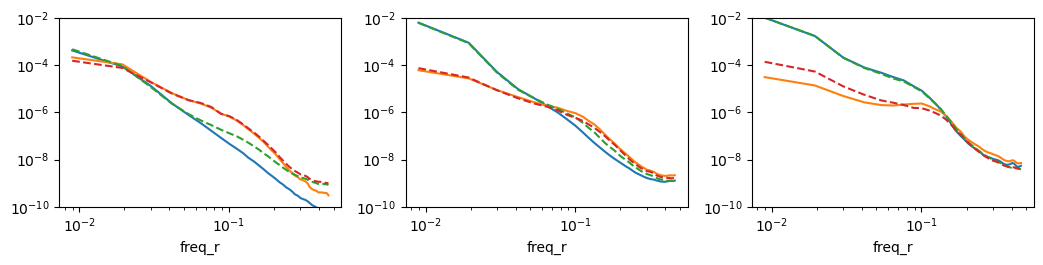

In [10]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_samples)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_samples)

    plt.subplot(1,4,i+1)
    
    psd_bm.mean('sample').plot()
    psd_ubm.mean('sample').plot()

    psd_bm_pred.mean(['sample','stochastic_sample']).plot(linestyle='dashed')
    psd_ubm_pred.mean(['sample','stochastic_sample']).plot(linestyle='dashed')
    
    
    #plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

## ESRs

Testing the accuracy of the predictions, and since each 

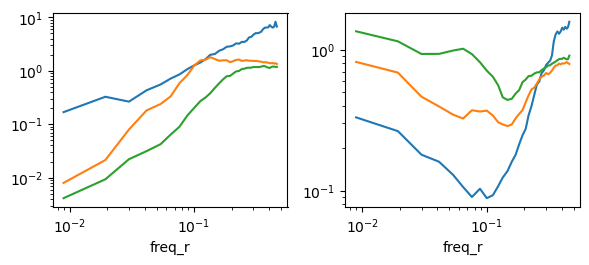

In [11]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(6,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    psd_bm_err = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean - ds.sel(sample=samps).bm_truth)
    psd_ubm_err = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean - ds.sel(sample=samps).ubm_truth)

    esr_bm = psd_bm_err.mean('sample')/psd_bm.mean('sample')
    esr_ubm = psd_ubm_err.mean('sample')/psd_ubm.mean('sample')
    
    plt.subplot(1,2,1)
    esr_bm.plot()
    plt.xscale('log')
    plt.yscale('log')

    plt.subplot(1,2,2)
    esr_ubm.plot()

   
    #plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    #plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


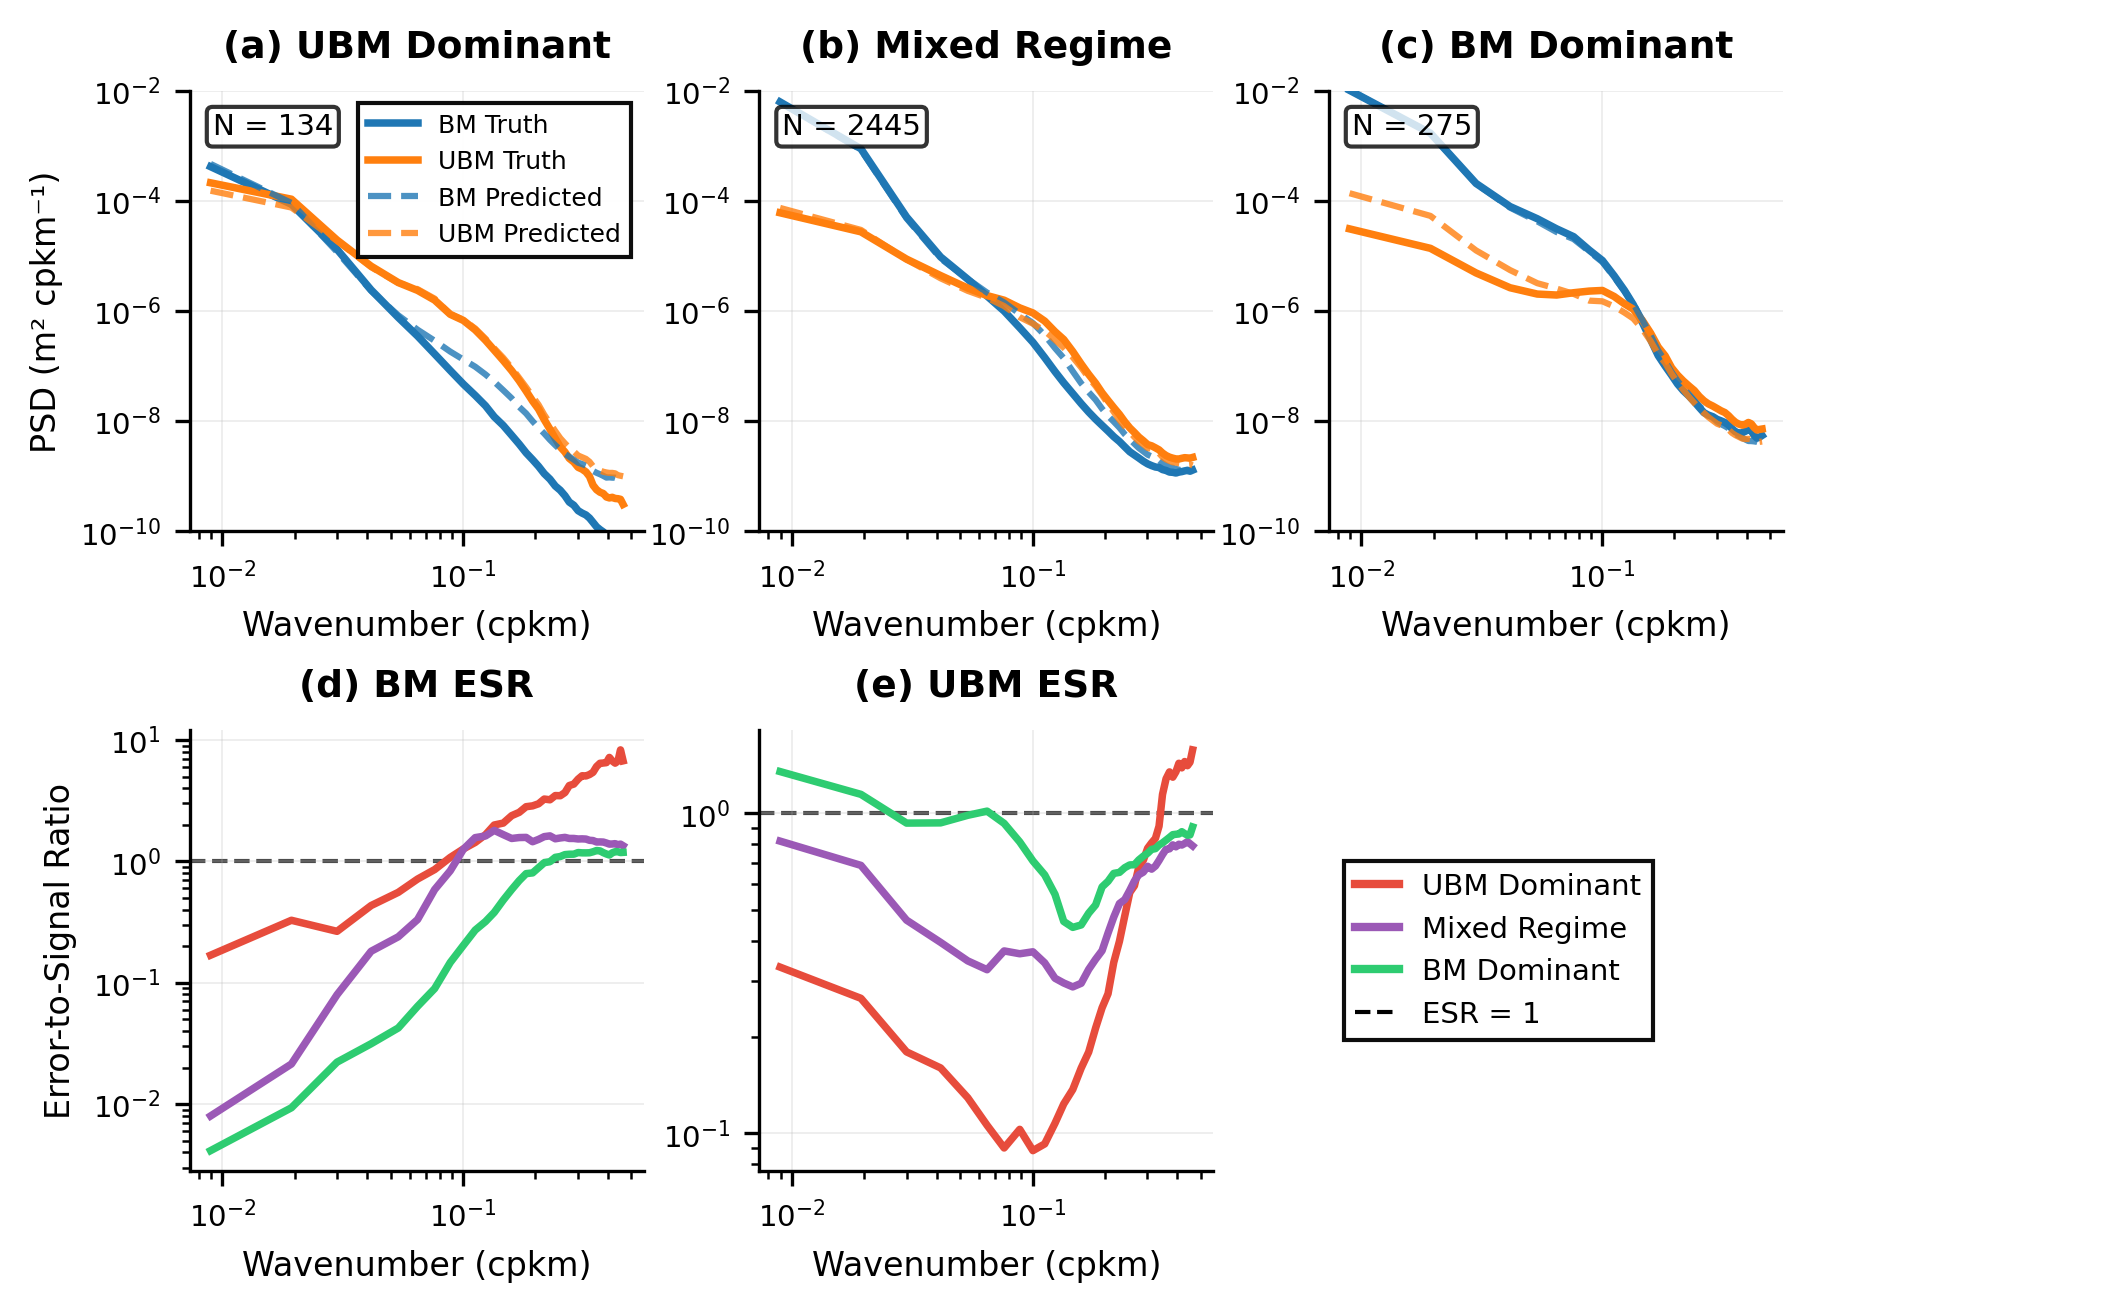

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec

# Set publication-quality parameters optimized for A4 print
rcParams['font.family'] = 'DejaVu Sans'  # Universally available sans-serif font
rcParams['font.size'] = 8          # Smaller base font for multi-panel figure
rcParams['axes.linewidth'] = 0.8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7
rcParams['legend.fontsize'] = 7
rcParams['axes.titlesize'] = 9
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300

# Colors for top row (PSD plots) - keep same as original
psd_colors = {
    'bm_truth': '#1f77b4',      # Blue for BM truth
    'ubm_truth': '#ff7f0e',     # Orange for UBM truth  
    'bm_pred': '#1f77b4',       # Same blue for BM pred (dashed)
    'ubm_pred': '#ff7f0e'       # Same orange for UBM pred (dashed)
}

# Different colors for bottom row (ESR plots) - more distinct regime colors
regime_colors = {
    0: '#e74c3c',    # Red for UBM Dominant
    1: '#9b59b6',    # Purple for Mixed Regime  
    2: '#2ecc71'     # Green for BM Dominant
}

bin_labels = [
    'UBM Dominant',
    'Mixed Regime', 
    'BM Dominant'
]

# Create figure optimized for publication (will be part of 8-panel figure)
# Standard journal double-column width is ~7 inches
fig = plt.figure(figsize=(7, 4.5))  # Optimized for A4, double-column format
gs = GridSpec(2, 4, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.4], 
              hspace=0.45, wspace=0.3, left=0.08, right=0.98, top=0.92, bottom=0.12)

# Get your data
ds = eval_datasets['sst_ssh']

# ============================================================================
# TOP ROW: PSD Analysis by Scale Regime (3 panels)
# ============================================================================

# Store ESR data for bottom row
esr_data = {'bm': [], 'ubm': [], 'labels': []}

for i, k in enumerate(bins.keys()): 
    ax = fig.add_subplot(gs[0, i])
    samps = bins[k]
    
    # Calculate PSDs for top row
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)
    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_samples)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_samples)
    
    # Plot truth (solid lines) - slightly thinner for publication
    psd_bm.mean('sample').plot(ax=ax, color=psd_colors['bm_truth'], linewidth=1.8, 
                               label='BM Truth', linestyle='-')
    psd_ubm.mean('sample').plot(ax=ax, color=psd_colors['ubm_truth'], linewidth=1.8, 
                                label='UBM Truth', linestyle='-')
    
    # Plot predictions (dashed lines)
    psd_bm_pred.mean(['sample','stochastic_sample']).plot(ax=ax, color=psd_colors['bm_pred'], 
                                                          linewidth=1.5, label='BM Predicted', 
                                                          linestyle='--', alpha=0.8)
    psd_ubm_pred.mean(['sample','stochastic_sample']).plot(ax=ax, color=psd_colors['ubm_pred'], 
                                                           linewidth=1.5, label='UBM Predicted', 
                                                           linestyle='--', alpha=0.8)
    
    # Set scales and limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-10, 1e-2])
    
    # Add labels and title
    ax.set_xlabel('Wavenumber (cpkm)')
    if i == 0:
        ax.set_ylabel('PSD (m² cpkm⁻¹)')
    else:
        ax.set_ylabel('')
    
    # Add subplot label and title - starting from (d)
    ax.set_title(f'({chr(97+i)}) {bin_labels[i]}', fontweight='bold', pad=8)
    
    # Add grid - lighter for publication
    ax.grid(True, alpha=0.25, linewidth=0.4)
    
    # Add legend (only on first subplot) - smaller for publication
    if i == 0:
        ax.legend(frameon=True, fancybox=False, edgecolor='black', 
                 framealpha=0.95, loc='upper right', fontsize=6)
    
    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    # Add sample count annotation - smaller font
    n_samples = len(samps)
    ax.text(0.05, 0.95, f'N = {n_samples}', transform=ax.transAxes, 
            fontsize=7, verticalalignment='top', 
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# ============================================================================
# BOTTOM ROW: ESR Analysis by Scale Regime (2 panels)
# ============================================================================

# Calculate ESR data for all bins
for i, k in enumerate(bins.keys()):
    samps = bins[k]
    
    # Calculate ESR data
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)
    psd_bm_err = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean - ds.sel(sample=samps).bm_truth)
    psd_ubm_err = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean - ds.sel(sample=samps).ubm_truth)
    
    esr_bm = psd_bm_err.mean('sample')/psd_bm.mean('sample')
    esr_ubm = psd_ubm_err.mean('sample')/psd_ubm.mean('sample')
    
    esr_data['bm'].append(esr_bm)
    esr_data['ubm'].append(esr_ubm)
    esr_data['labels'].append(f'{bin_labels[i]}')

# Panel G: BM ESR (bottom left)
ax4 = fig.add_subplot(gs[1, 0])
for i in range(len(bins.keys())):
    esr_data['bm'][i].plot(ax=ax4, color=regime_colors[i], linewidth=1.8, 
                           label=esr_data['labels'][i])

ax4.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7, 
            label='ESR = 1', zorder=0)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Wavenumber (cpkm)')
ax4.set_ylabel('Error-to-Signal Ratio')
ax4.set_title('(d) BM ESR', fontweight='bold', pad=8)
ax4.grid(True, alpha=0.25, linewidth=0.4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_linewidth(0.8)
ax4.spines['bottom'].set_linewidth(0.8)

# Panel H: UBM ESR (bottom center)  
ax5 = fig.add_subplot(gs[1, 1])
for i in range(len(bins.keys())):
    esr_data['ubm'][i].plot(ax=ax5, color=regime_colors[i], linewidth=1.8,
                            label=esr_data['labels'][i])

ax5.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7, 
            label='ESR = 1', zorder=0)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel('Wavenumber (cpkm)')
ax5.set_ylabel('')  # No y-label to save space
ax5.set_title('(e) UBM ESR', fontweight='bold', pad=8)
ax5.grid(True, alpha=0.25, linewidth=0.4)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['left'].set_linewidth(0.8)
ax5.spines['bottom'].set_linewidth(0.8)

# Create shared legend in the empty space (bottom right)
legend_ax = fig.add_subplot(gs[1, 2:])
legend_ax.axis('off')  # Hide the axes

# Create legend elements for the bottom row - compact for publication
legend_elements = []
for i in range(len(bins.keys())):
    legend_elements.append(plt.Line2D([0], [0], color=regime_colors[i], linewidth=2, 
                                     label=esr_data['labels'][i]))
legend_elements.append(plt.Line2D([0], [0], color='black', linewidth=1, 
                                 linestyle='--', label='ESR = 1'))

legend_ax.legend(handles=legend_elements, loc='center left', frameon=True, 
                fancybox=False, edgecolor='black', framealpha=0.95, fontsize=7,
                handlelength=1.5, columnspacing=0.8)

# Save the figure in multiple formats for journal submission
plt.savefig('figure_5panel_scale_regimes.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', pad_inches=0.02)
plt.savefig('figure_5panel_scale_regimes.eps', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', pad_inches=0.02)
plt.savefig('figure_5panel_scale_regimes.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', pad_inches=0.02)

plt.show()


## Scratch

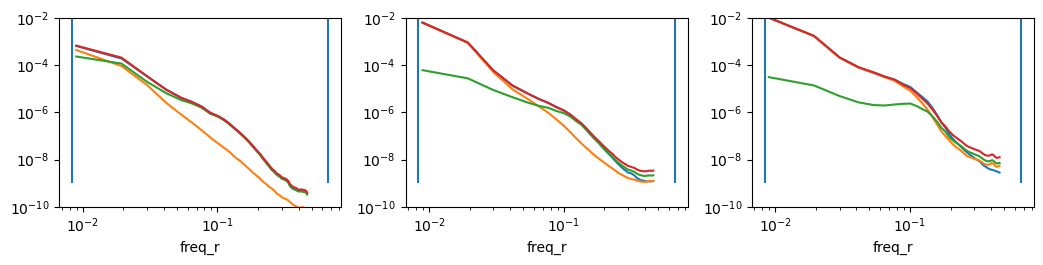

In [19]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    plt.subplot(1,4,i+1)
    psd_ssh_raw.mean('sample').plot()
    psd_bm.mean('sample').plot()
    psd_ubm.mean('sample').plot()
    (psd_bm.mean('sample') + psd_ubm.mean('sample')).plot()
    
    plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

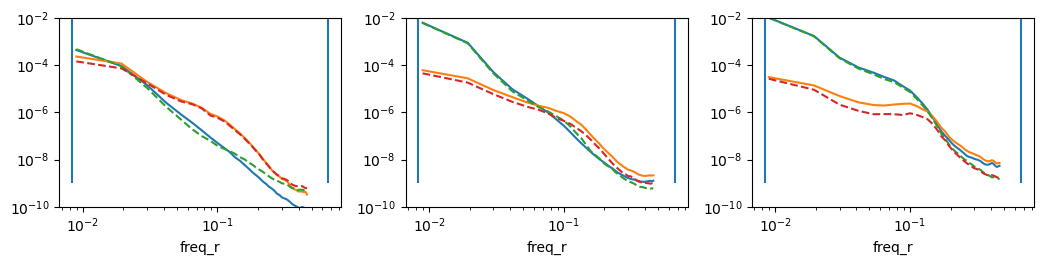

In [21]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean)

    plt.subplot(1,4,i+1)
    
    psd_bm.mean('sample').plot()
    psd_ubm.mean('sample').plot()

    psd_bm_pred.mean('sample').plot(linestyle='dashed')
    psd_ubm_pred.mean('sample').plot(linestyle='dashed')
    
    
    plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

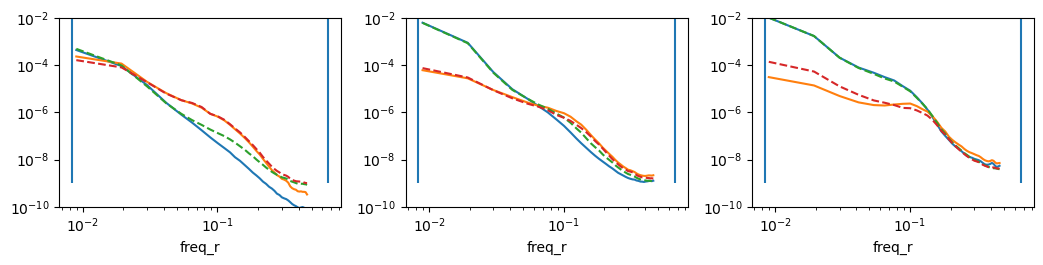

In [22]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_samples)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_samples)

    plt.subplot(1,4,i+1)
    
    psd_bm.mean('sample').plot()
    psd_ubm.mean('sample').plot()

    psd_bm_pred.mean(['sample','stochastic_sample']).plot(linestyle='dashed')
    psd_ubm_pred.mean(['sample','stochastic_sample']).plot(linestyle='dashed')
    
    
    plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

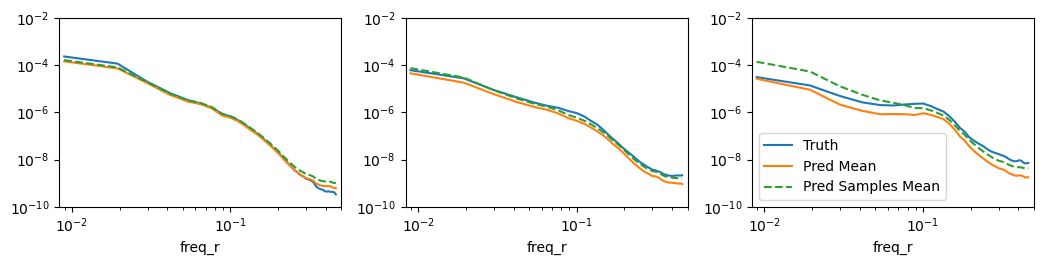

In [24]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    #psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    #psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean)
    #psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean)

    psd_ubm_mean_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean)

    psd_ubm_pred_samples = isotropic_spectra(ds.sel(sample=samps).ubm_pred_samples)
    
    plt.subplot(1,4,i+1)
    
    psd_ubm.mean('sample').plot(label='Truth')
    psd_ubm_mean_pred.mean('sample').plot(label='Pred Mean')
    #psd_ubm_pred.mean('sample').plot()
    psd_ubm_pred_samples.mean(['sample','stochastic_sample']).plot(label='Pred Samples Mean', linestyle='dashed')

    #psd_ubm_pred.quantile(0.05, ['sample']).plot(linestyle='dashed')
    #psd_ubm_pred.quantile(.95, ['sample']).plot(linestyle='dashed')
    
    
    #plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xlim([1/120, 1/2])
    plt.xscale('log')
    plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.show()